# Model Comparison and Final Selection

In this notebook, we bring together everything we've done so far — cleaned data, engineered features, and geospatial context—to train, compare, and tune multiple regression models. Our goal is to find the best-performing model for predicting housing prices.

You'll walk through:
- Setting up a flexible pipeline with encoding and transformations
- Comparing linear and tree-based regressors
- Fine-tuning a gradient boosting model (LGBM)
- Evaluating performance with metrics, plots, and residuals
- Saving the best model for later use

By the end, we’ll have a production-ready model and a clear picture of how different modeling strategies stack up.



Let’s load all necessary packages, including model evaluation tools, data transformers, and regressors. We also bring in project-specific utilities to keep things modular and consistent.

Then, we load the dataset and separate it into features and target variable. 


In [ ]:
%load_ext autoreload
%autoreload 2

import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    MinMaxScaler,
    OneHotEncoder,
    PolynomialFeatures,
    PowerTransformer,
    QuantileTransformer,
)

# tree
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

# SVM
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import SGDRegressor
from sklearn.svm import LinearSVR

# kNN
from sklearn.neighbors import KNeighborsRegressor

from joblib import dump
from pprint import pprint

from california.config import BEST_MODEL_FILE, INTERIM_DATA_FILE
from california.plots import (
    plot_compare_model_metrics,
    plot_importance_lgbm,
    plot_residuals_from_estimator,
)

from california.models import (
    cross_validate_regression_model,
    grid_search_regression_model,
    organize_cv_results,
    RANDOM_STATE
)

In [2]:
df = pd.read_parquet(INTERIM_DATA_FILE)

df.head()

,latitude,longitude,housing_median_age,total_rooms,population,median_income,rooms_per_household,population_per_household,bedrooms_per_room,ocean_proximity,median_income_cat,median_house_value
0,37.88,-122.23,41,880,322,8.3252,6.984127,2.555556,0.146591,NEAR BAY,1,452600
1,37.84,-122.26,42,2555,1206,2.0804,4.294118,2.026891,0.260274,NEAR BAY,2,226700
2,37.85,-122.26,50,1120,697,2.1250,4.242424,2.640152,0.252679,NEAR BAY,2,140000
3,37.84,-122.26,50,2239,990,1.9911,5.343675,2.362768,0.203216,NEAR BAY,2,158700
4,37.85,-122.27,40,751,409,1.3578,4.524096,2.463855,0.245007,NEAR BAY,2,147500


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17889 entries, 0 to 17888
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   latitude                  17889 non-null  float64 
 1   longitude                 17889 non-null  float64 
 2   housing_median_age        17889 non-null  int8    
 3   total_rooms               17889 non-null  int16   
 4   population                17889 non-null  int16   
 5   median_income             17889 non-null  float64 
 6   rooms_per_household       17889 non-null  float64 
 7   population_per_household  17889 non-null  float64 
 8   bedrooms_per_room         17889 non-null  float64 
 9   ocean_proximity           17889 non-null  category
 10  median_income_cat         17889 non-null  int32   
 11  median_house_value        17889 non-null  int32   
dtypes: category(1), float64(6), int16(2), int32(2), int8(1)
memory usage: 1.1 MB


In [4]:
target = ["median_house_value"]
features_one_hot = [
    "ocean_proximity",
    "median_income_cat",
]
features_numeric = [
    column
    for column in df.columns
    if column not in (target + features_one_hot)
]

features_to_print = [target, features_one_hot, features_numeric]

for feature in features_to_print:
    pprint(feature)

['median_house_value']
['ocean_proximity', 'median_income_cat']
['latitude',
 'longitude',
 'housing_median_age',
 'total_rooms',
 'population',
 'median_income',
 'rooms_per_household',
 'population_per_household',
 'bedrooms_per_room']


In [5]:
X = df.drop(columns=target)
y = df[target].values.ravel()


Next, let's define some distinct preprocessing pipelines for different types of models. We'll use `ColumnTransformer` to handle categorical and numerical features separately, applying appropriate transformations like one-hot encoding and scaling.


In [6]:
pipeline_poly = Pipeline(
    steps=[
        ("power_transformer", PowerTransformer()),
        ("poly_features", PolynomialFeatures(degree=2, include_bias=False)),
    ]
)

pipeline_min_max_knn = Pipeline(steps=[("min_max_scaler", MinMaxScaler())])

pipeline_nystroem = Pipeline(
    steps=[
        ("power_transformer", PowerTransformer()),
        ("nystroem", Nystroem(random_state=RANDOM_STATE, n_jobs=-1)),
    ]
)

preprocessing_simple = ColumnTransformer(
    transformers=[
        ("num", PowerTransformer(), features_numeric),
        (
            "cat",
            OneHotEncoder(handle_unknown="ignore", drop="if_binary"),
            features_one_hot,
        ),
    ],
    remainder="drop",
)

preprocessing_tree = ColumnTransformer(
    transformers=[
        (
            "cat",
            OneHotEncoder(handle_unknown="ignore", drop="if_binary"),
            features_one_hot,
        ),
    ],
    remainder="passthrough",
)

preprocessing_poly = ColumnTransformer(
    transformers=[
        ("num", pipeline_poly, features_numeric),
        (
            "cat",
            OneHotEncoder(handle_unknown="ignore", drop="if_binary"),
            features_one_hot,
        ),
    ],
    remainder="drop",
)

preprocessing_nystroem = ColumnTransformer(
    transformers=[
        ("num", pipeline_nystroem, features_numeric),
        (
            "cat",
            OneHotEncoder(handle_unknown="ignore", drop="if_binary"),
            features_one_hot,
        ),
    ],
    remainder="drop",
)

preprocessing_knn = ColumnTransformer(
    transformers=[
        ("num", pipeline_min_max_knn, features_numeric),
        (
            "cat",
            OneHotEncoder(handle_unknown="ignore", drop="if_binary"),
            features_one_hot,
        ),
    ],
    remainder="drop",
)

target_transformer = QuantileTransformer(
    output_distribution="normal", random_state=42
)


Here we define a dictionary of models we want to try out— some basic like `DummyRegressor`, some regularized linear models, a few tree-based options, SVR, and KNN. This allows us to easily loop through and evaluate each model without repeating code.


In [7]:

regressors = {
    "DummyRegressor": {
        "preprocessor": None,
        "regressor": DummyRegressor(strategy="mean"),
        "target_transformer": None,
    },
    "ElasticNet_target_poly": {
        "preprocessor": preprocessing_poly,
        "regressor": ElasticNet(alpha=0.01, l1_ratio=0.1),
        "target_transformer": target_transformer,
    },
    "DecisionTreeRegressor": {
        "preprocessor": preprocessing_tree,
        "regressor": DecisionTreeRegressor(random_state=RANDOM_STATE),
        "target_transformer": None,
    },
    "LGBMRegressor": {
        "preprocessor": preprocessing_tree,
        "regressor": LGBMRegressor(random_state=RANDOM_STATE, verbose=-1, n_jobs=-1),
        "target_transformer": None,
    },
    "XGBRegressor": {
        "preprocessor": preprocessing_tree,
        "regressor": XGBRegressor(random_state=RANDOM_STATE),
        "target_transformer": None,
    },

    "SGDRegressor": {
        "preprocessor": preprocessing_nystroem,
        "regressor": SGDRegressor(random_state=RANDOM_STATE),
        "target_transformer": target_transformer,
    },
    "LinearSVR": {
        "preprocessor": preprocessing_nystroem,
        "regressor": LinearSVR(random_state=RANDOM_STATE),
        "target_transformer": target_transformer,
    },
    "KNeighborsRegressor": {
        "preprocessor": preprocessing_knn,
        "regressor": KNeighborsRegressor(n_neighbors=5),
        "target_transformer": None,
    },
}


We evaluate all models with cross-validation. This gives us a reliable estimate of how well each model performs on unseen data.


In [8]:
results = {
    model_name: cross_validate_regression_model(X, y, **classifier)
    for model_name, classifier in regressors.items()
}

df_results = organize_cv_results(results)

df_results

/opt/anaconda/envs/california_housing/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda/envs/california_housing/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda/envs/california_housing/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda/envs/california_housing/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda/envs/california_housing/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid 

,model,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
0,DummyRegressor,0.005083,0.006311,-0.000654,-75966.60759,-95675.18693,0.011394
1,DummyRegressor,0.003904,0.003879,-0.000398,-75832.432601,-94467.197536,0.007784
2,DummyRegressor,0.003215,0.006212,-0.000009,-74851.688406,-93978.824732,0.009427
3,DummyRegressor,0.004321,0.003309,-0.000052,-77050.183031,-96858.605837,0.007629
4,DummyRegressor,0.004141,0.002271,-0.000261,-75878.31092,-95130.339097,0.006412
5,ElasticNet_target_poly,1.847362,0.023498,0.694028,-36846.37518,-52905.171265,1.870861
6,ElasticNet_target_poly,1.483845,0.026349,0.68262,-36339.667604,-53208.947449,1.510195
7,ElasticNet_target_poly,2.49557,0.053408,0.697929,-35504.796268,-51651.495956,2.548978
8,ElasticNet_target_poly,0.801088,0.02692,0.708836,-36251.763235,-52263.174592,0.828007
9,ElasticNet_target_poly,2.070052,0.023912,0.718325,-34811.453015,-50481.985277,2.093965


In [9]:
df_results.groupby("model").mean().sort_values("test_neg_root_mean_squared_error")

,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
model,,,,,,
DummyRegressor,0.004133,0.004396,-0.000275,-75915.84451,-95222.030826,0.008529
DecisionTreeRegressor,0.274874,0.009766,0.573312,-41221.797289,-62153.718786,0.284641
SGDRegressor,0.758692,0.061433,0.664507,-38888.23017,-55130.185835,0.820125
KNeighborsRegressor,0.026689,0.141476,0.680538,-36943.28769,-53788.168281,0.168165
ElasticNet_target_poly,1.739584,0.030818,0.700348,-35950.81106,-52102.154908,1.770401
LinearSVR,1.08707,0.058215,0.702261,-35362.324318,-51936.385658,1.145285
XGBRegressor,2.174542,0.016361,0.811473,-27594.836328,-41329.778125,2.190903
LGBMRegressor,1.350505,0.018253,0.81162,-27891.012396,-41311.98196,1.368758



This chart makes it easier to compare model performance side-by-side. Look for low RMSE and stable results across metrics.


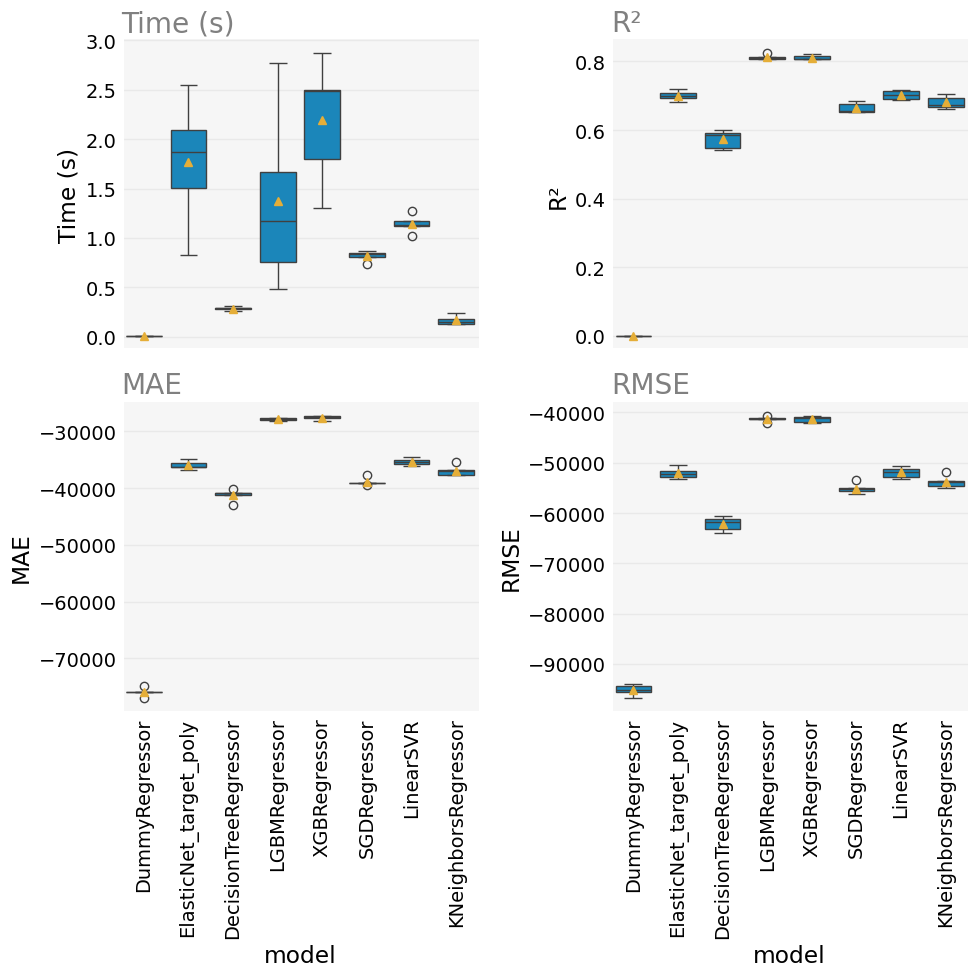

In [10]:
plot_compare_model_metrics(df_results, figsize=(10, 10))


Based on the initial comparisons, we now focus on LightGBM since it has shown the best performance considering metrics and has a good balance of speed and metrics. We will fine-tune its hyperparameters using `GridSearchCV` to squeeze out the best possible performance. 


In [ ]:
lgbm_regressor = LGBMRegressor(
    random_state=RANDOM_STATE, verbose=-1, device="cuda"
)

param_grid = {
    "reg__max_depth": [10, 20],  # Max depth of the tree (<= 0 means no limit)
    "reg__num_leaves": [20, 31, 50],  # Max number of leaves in one tree
    "reg__min_child_samples": [20, 50],  # Minimum number of samples in a leaf
    "reg__min_split_gain": [0.0, 0.1, 0.3],  # Minimum loss reduction required to make a further partition on a leaf node
    "reg__subsample": [0.6, 0.8, 1.0],  # Proportion of samples to use for fitting each tree
    "reg__colsample_bytree": [0.6, 0.8, 1.0],  # Proportion of features to use for fitting each tree
    "reg__learning_rate": [0.05, 0.1],  # Learning rate
    "reg__n_estimators": [100, 500],  # Number of estimators (trees) to fit
    "reg__reg_alpha": [0.0, 1.0, 5.0],  # L1 regularization term on weights
    "reg__reg_lambda": [0.0, 1.0, 5.0],  # L2 regularization term on weights
}

grid_search = grid_search_regression_model(
    regressor=lgbm_regressor,
    param_grid=param_grid,
    preprocessor=preprocessing_tree,
    target_transformer=None,
)

grid_search

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat',
                                                                         OneHotEncoder(drop='if_binary',
                                                                                       handle_unknown='ignore'),
                                                                         ['ocean_proximity',
                                                                          'median_income_cat'])])),
                                       ('reg',
                                        LGBMRegressor(device='cuda',
                                                      random_state=42,
                                                      verbose=-1))]),
             n_jobs=-1,
             param_grid={'reg__colsample_bytree': [0.6, 0.8, 1.0],
                         'reg__learning_rate': [0.05, 0.1],
                         'reg__max_depth': [10, 20],
                         'reg__n_estimators': [100, 500],
                         'reg__reg_alpha': [0.0, 1.0, 5.0],
                         'reg__reg_lambda': [0.0, 1.0, 5.0],
                         'reg__subsample': [0.6, 0.8, 1.0]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

In [ ]:
grid_search.fit(X, y)

In [15]:
grid_search.best_params_

{'reg__colsample_bytree': 0.8,
 'reg__learning_rate': 0.1,
 'reg__max_depth': 20,
 'reg__n_estimators': 500,
 'reg__reg_alpha': 5.0,
 'reg__reg_lambda': 5.0,
 'reg__subsample': 0.8}

In [16]:
grid_search.best_score_

np.float64(-39283.74669121028)

In [17]:
grid_search.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore'),
                                                  ['ocean_proximity',
                                                   'median_income_cat'])])),
                ('reg',
                 LGBMRegressor(colsample_bytree=0.8, device='cuda',
                               max_depth=20, n_estimators=500, random_state=42,
                               reg_alpha=5.0, reg_lambda=5.0, subsample=0.8,
                               verbose=-1))])


Let’s see which features the model leaned on most. Feature importances from LGBM help us understand which variables drive price predictions.


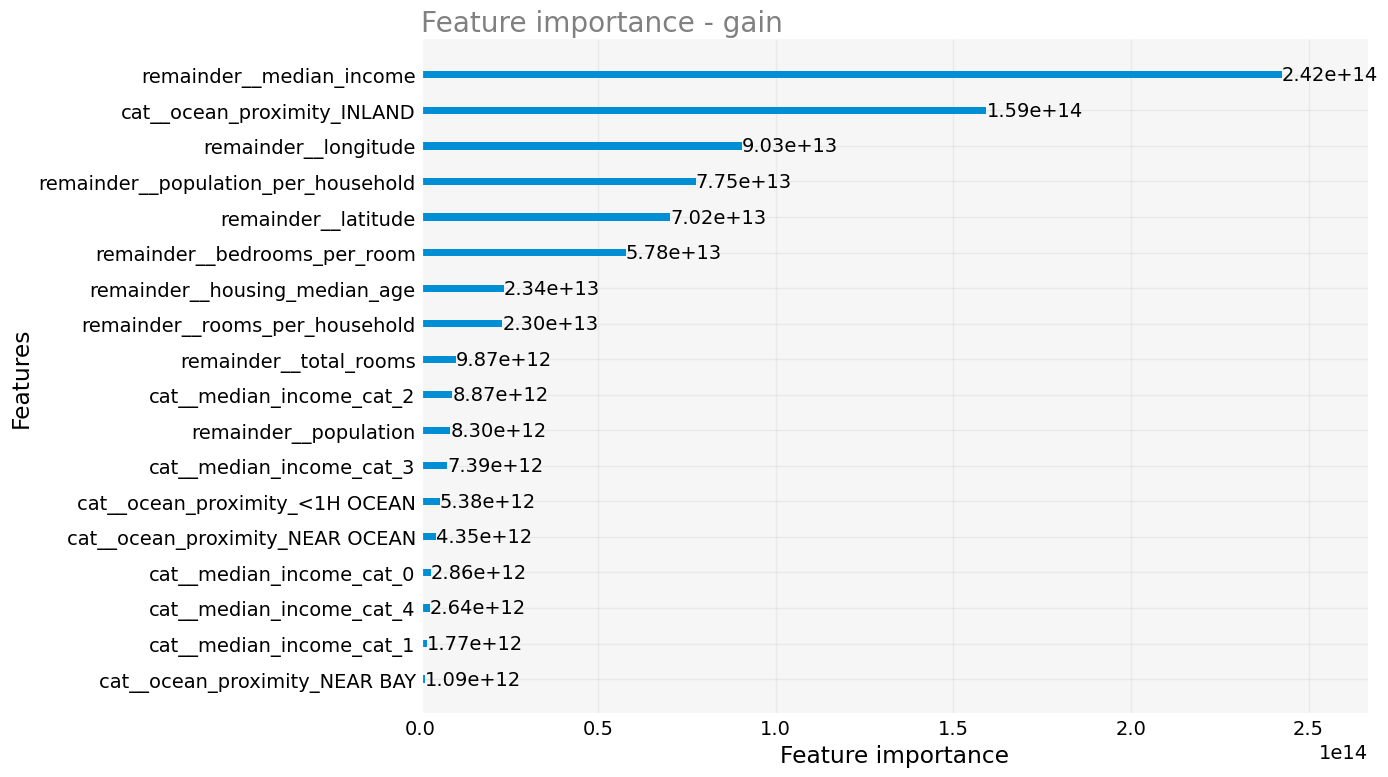

In [ ]:

plot_importance_lgbm(
    grid_search.best_estimator_,
    importance_type="gain",
)


A residual plot gives a sense of model fit quality. We want residuals that look random—not structured—which means the model isn’t systematically off.


/opt/anaconda/envs/california_housing/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda/envs/california_housing/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


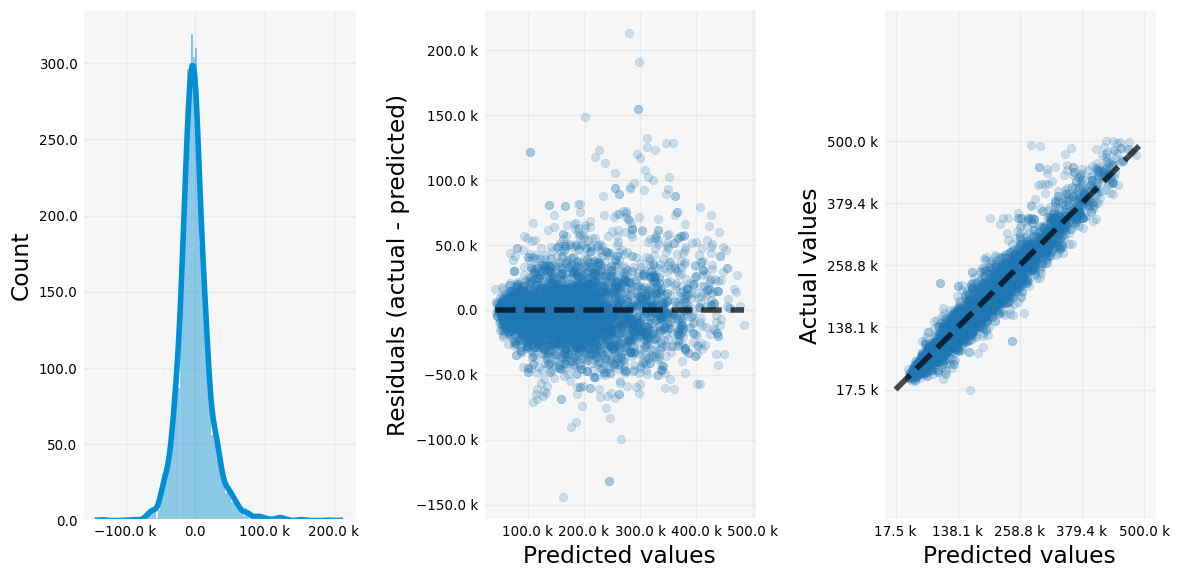

In [38]:
plot_residuals_from_estimator(
    grid_search.best_estimator_,
    X,
    y,
    eng_formatter=True,
)


The final model gets serialized with `joblib` so it can be loaded later without retraining. This wraps up the modeling workflow.


In [20]:
dump(grid_search.best_estimator_, BEST_MODEL_FILE)

['/home/chicolucio/Dropbox/technology/python/projects/ml/california/models/best_model.joblib']

Now we have a solid model ready for deployment. We will build a web application to serve predictions.